In [1]:
### Reloads modules properly
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.sys.path.append('../')

# Classification Debugging

In [5]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplhep as hep
hep.style.use('CMS')

In [41]:
from sklearn.cluster import DBSCAN

Using small scale test files as an example (25k PV's)

In [6]:
!ls -lh /mnt/storage/lborgna/track/l1_nnt

total 7.2G
-rw-r--r-- 1 lborgna users  2.2M Dec  6 15:00 mc_25k.pkl
-rw-r--r-- 1 lborgna users  5.4M Nov 25 15:32 mc.pkl
-rw-r--r-- 1 lborgna users  4.9G Nov 24 17:09 OldKF_TTbar_170K_quality.root
-rw-r--r-- 1 lborgna users  128M Dec  6 14:59 tp_25k.pkl
-rw-r--r-- 1 lborgna users  1.2G Nov 25 15:31 tp.pkl
-rw-r--r-- 1 lborgna users  115M Dec  6 14:59 trk_25k.pkl
-rw-r--r-- 1 lborgna users 1013M Nov 25 15:31 trk.pkl


In [7]:
storage = '/mnt/storage/lborgna/track/l1_nnt/'
tp = pd.read_pickle(storage + 'tp_25k.pkl')
trk = pd.read_pickle(storage + 'trk_25k.pkl')
mc = pd.read_pickle(storage + 'mc_25k.pkl')

## Pre-processing

In [274]:
trk = trk.loc[trk['trk_pt'] !=np.inf].copy()

In [79]:
# f = uproot.open(storage+'OldKF_TTbar_170K_quality.root')

In [84]:
# fake_label = f['L1TrackNtuple/eventTree;1'].arrays(['trk_fake'], library='pd')

In [85]:
# fake_label = fake_label.query('entry < 25000')

In [87]:
# trk['trk_fake'] = fake_label.values

In [90]:
# trk.drop(columns=['db_label']).to_pickle(storage+'trk_25k.pkl')

In [10]:
from pv_utils import (
    truth_pv_z0,
    run_fast_histo,
    run_dbscan,
    primary_vertex_efficiency,
    plot_pv_efficiency_z0,
    plot_pv_resolution_z0,
)

In [11]:
z0_gen = truth_pv_z0(tp)

In [17]:
z0_mc = mc['pv_MC'].xs(0, axis = 0, level = 1, drop_level=True)

In [18]:
help(run_dbscan)

Help on function run_dbscan in module pv_utils:

run_dbscan(df: pandas.core.frame.DataFrame, z0_column: str = 'trk_z0', pt_column: str = 'trk_pt', eps: float = 0.08, minPts: int = 2, remove_noise: bool = False) -> pandas.core.frame.DataFrame
    run dbscan



In [19]:
z0_db_old = run_dbscan(trk, remove_noise=True)

In [53]:
z0_db_old_wnoise = run_dbscan(trk, remove_noise=False)

In [23]:
z0_db_old.head()

,dbscan_labels,z0,pt
entry,,,
0,17.0,4.980469,84.025032
1,16.0,-3.603516,104.907082
2,39.0,-0.175781,226.240372
3,28.0,2.753906,301.090637
4,67.0,-1.289062,270.321960


In [24]:
primary_vertex_efficiency(z0_gen=z0_gen, z0_reco=z0_db_old['z0'])

(74.73296795615474, 0.5435442043590797, 0.5377888957577568)

In [54]:
primary_vertex_efficiency(z0_gen=z0_gen, z0_reco=z0_db_old_wnoise['z0'])

(70.00440052806337, 0.5723640217773891, 0.5677102163357972)

In [26]:
be = np.arange(-15, 16, 1)

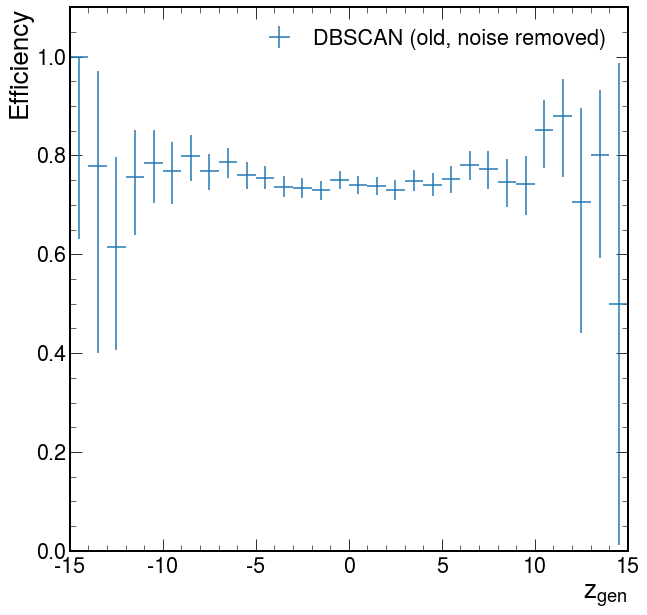

In [30]:
_ = plot_pv_efficiency_z0(z0_gen=z0_gen, z0_reco=z0_db_old['z0'], bin_edges=be, xlim=[-15, 15], label = 'DBSCAN (old, noise removed)')

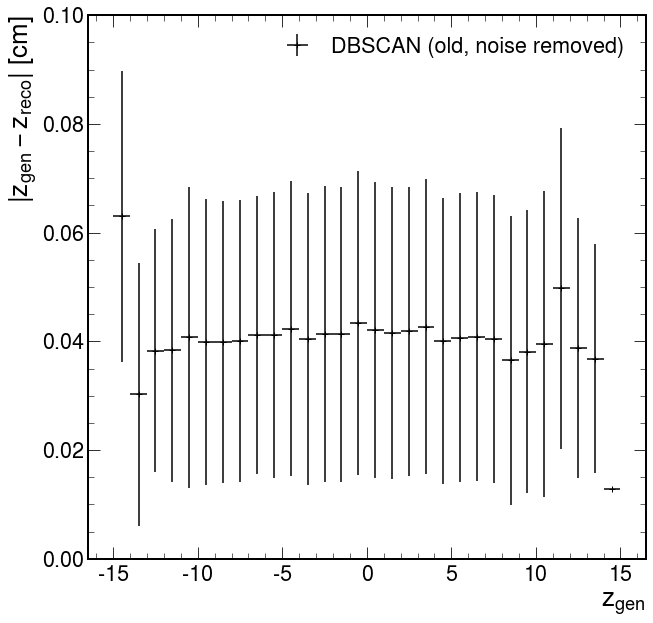

In [37]:
_= plot_pv_resolution_z0(z0_gen=z0_gen, z0_reco=z0_db_old['z0'], bins = be, label = 'DBSCAN (old, noise removed)')

# New way to DBSCAN (Allows for classification accuracy)

In [38]:
def pv_dbscan_event(z0: pd.Series, pt: pd.Series, eps:float=0.08, minPts:int=2)->pd.Series:
    
    _df = pd.DataFrame({})
    _df['z0'] = z0
    _df['pt'] = pt
    
    db_clustering = DBSCAN(eps = eps, min_samples = minPts).fit(_df['z0'].values.reshape(-1, 1))
    
    _df['db_label'] = db_clustering.labels_
    
    _df.loc[_df['db_label']==-1, 'pt'] = 0
    
    pv_label = _df.groupby(['db_label'])['pt'].sum().sort_values(ascending=False).index[0]
    
    _df['db_pv_label'] = 0 
    
    _df.loc[_df['db_label']==pv_label, 'db_pv_label' ] = 1
    
    return _df['db_pv_label'] 

In [62]:
def run_new_dbscan(
    df: pd.DataFrame,
    z0_column: str = "trk_z0",
    pt_column: str = "trk_pt",
    eps: float = 0.08,
    minPts: int = 2,
) -> pd.DataFrame:

    pv_dbscan = df.groupby(level=0).apply(
        lambda x: pv_dbscan_event(x[z0_column], x[pt_column], eps, minPts)
    )
    
    return pv_dbscan.values 


In [63]:
trk['db_label'] = run_new_dbscan(trk)

In [44]:
trk['db_label'] = new_dbscan.values

In [64]:
z0_db_new = trk.loc[trk['db_label']==1].groupby(['entry'])['trk_z0'].median().reset_index()

In [65]:
z0_db_new

,entry,trk_z0
0,0,4.980469
1,1,-3.603516
2,2,-0.175781
3,3,2.753906
4,4,-1.289062
...,...,...
24995,24995,0.000000
24996,24996,-1.933594
24997,24997,8.085938
24998,24998,-4.804688


In [66]:
primary_vertex_efficiency(z0_gen=z0_gen, z0_reco=z0_db_new['trk_z0'])

(74.73296795615474, 0.5435442043590797, 0.5377888957577568)

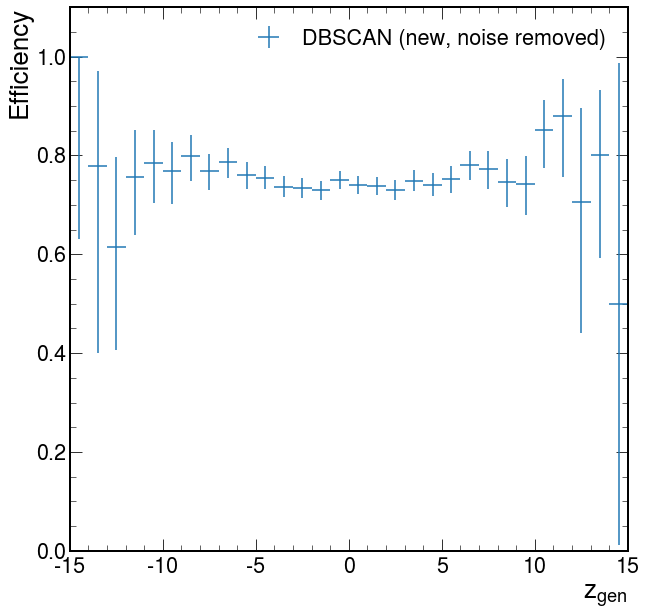

In [59]:
_ = plot_pv_efficiency_z0(z0_gen=z0_gen, z0_reco=z0_db_new['trk_z0'], bin_edges=be, xlim=[-15, 15], label = 'DBSCAN (new, noise removed)')

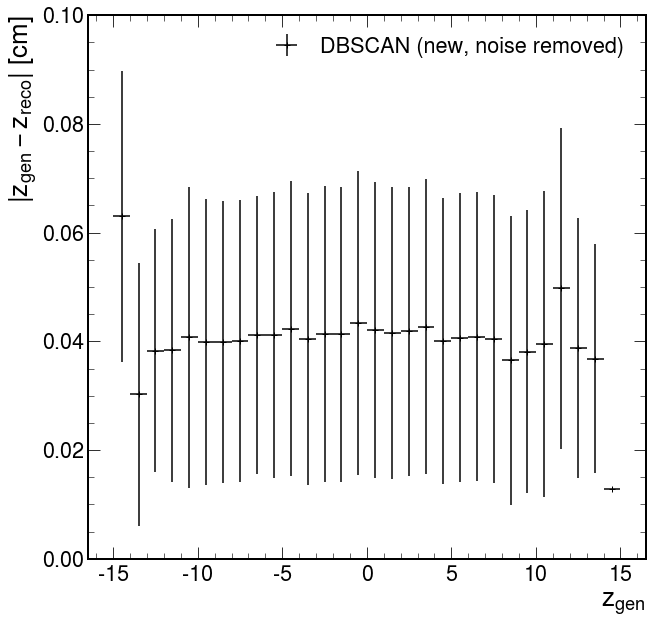

In [61]:
_= plot_pv_resolution_z0(z0_gen=z0_gen, z0_reco=z0_db_new['trk_z0'], bins = be, label = 'DBSCAN (new, noise removed)')

# Classification Accuracy

In [91]:
from pv_utils import run_pv_fast_histo, run_pv_dbscan

In [94]:
trk['db_label'] = run_pv_dbscan(trk)

100%|█████████████████████████████████████████████████████████| 25000/25000 [01:47<00:00, 232.81it/s]


In [96]:
be_fh = np.arange(-15, 15+0.3, 0.3)

In [97]:
be_fh

array([-1.50000000e+01, -1.47000000e+01, -1.44000000e+01, -1.41000000e+01,
       -1.38000000e+01, -1.35000000e+01, -1.32000000e+01, -1.29000000e+01,
       -1.26000000e+01, -1.23000000e+01, -1.20000000e+01, -1.17000000e+01,
       -1.14000000e+01, -1.11000000e+01, -1.08000000e+01, -1.05000000e+01,
       -1.02000000e+01, -9.90000000e+00, -9.60000000e+00, -9.30000000e+00,
       -9.00000000e+00, -8.70000000e+00, -8.40000000e+00, -8.10000000e+00,
       -7.80000000e+00, -7.50000000e+00, -7.20000000e+00, -6.90000000e+00,
       -6.60000000e+00, -6.30000000e+00, -6.00000000e+00, -5.70000000e+00,
       -5.40000000e+00, -5.10000000e+00, -4.80000000e+00, -4.50000000e+00,
       -4.20000000e+00, -3.90000000e+00, -3.60000000e+00, -3.30000000e+00,
       -3.00000000e+00, -2.70000000e+00, -2.40000000e+00, -2.10000000e+00,
       -1.80000000e+00, -1.50000000e+00, -1.20000000e+00, -9.00000000e-01,
       -6.00000000e-01, -3.00000000e-01,  3.55271368e-14,  3.00000000e-01,
        6.00000000e-01,  

In [275]:
trk['fh_label'] = run_pv_fast_histo(trk, bin_edges=be_fh)

100%|████████████████████████████████████████████████████████| 25000/25000 [00:13<00:00, 1823.02it/s]


In [276]:
trk['fh_label'] = trk['fh_label'].astype(int)

In [101]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

In [109]:
def trk_vertex_association(
    df: pd.DataFrame, true_label: str = "trk_fake", pred_label: str = "fh_label"
) -> dict:

    tn, fp, fn, tp = confusion_matrix(
        df[true_label].values, df[pred_label].values
    ).ravel()

    TPR = tp / (tp + fn)

    FPR = fp / (tn + fp)

    AUC = roc_auc_score(df[true_label].values, df[pred_label].values)

    return {"tn": tn, "fp": fp, "fn": fn, "tp": tp, "TPR": TPR, "FPR": FPR, "AUC": AUC}

In [102]:
trk['is_pv'] = 0
trk.loc[trk['trk_fake']==1, 'is_pv']=1

In [106]:
trk[[
    'is_pv', 'fh_label'
]].dtypes

is_pv       int64
fh_label    int64
dtype: object

In [277]:
trk_vertex_association(trk, true_label='is_pv', pred_label='fh_label')

{'tn': 3779528,
 'fp': 89442,
 'fn': 349686,
 'tp': 343880,
 'TPR': 0.4958143853649112,
 'FPR': 0.023117780701323608,
 'AUC': 0.7363483023317938}

In [111]:
trk_vertex_association(trk, true_label='is_pv', pred_label='db_label')

{'tn': 3632715,
 'fp': 236260,
 'fn': 148224,
 'tp': 545342,
 'TPR': 0.7862871017322072,
 'FPR': 0.06106526922505315,
 'AUC': 0.862610916253577}

In [112]:
print(
    classification_report(
        trk["is_pv"].values, trk["fh_label"].values, target_names=["not PV", "PV"]
    )
)

              precision    recall  f1-score   support

      not PV       0.92      0.98      0.95   3868975
          PV       0.79      0.49      0.61    693566

    accuracy                           0.90   4562541
   macro avg       0.85      0.74      0.78   4562541
weighted avg       0.90      0.90      0.89   4562541



In [113]:
print(
    classification_report(
        trk["is_pv"].values, trk["db_label"].values, target_names=["not PV", "PV"]
    )
)

              precision    recall  f1-score   support

      not PV       0.96      0.94      0.95   3868975
          PV       0.70      0.79      0.74    693566

    accuracy                           0.92   4562541
   macro avg       0.83      0.86      0.84   4562541
weighted avg       0.92      0.92      0.92   4562541



# plotting residuals

In [278]:
def pv_z0_reco(df:pd.DataFrame, reco_label:str='fh_label', z0_label:str='trk_z0') -> pd.DataFrame:
    
    return df.loc[df[reco_label]==1].groupby(['entry'])[z0_label].median().reset_index()

In [279]:
fh_z0 = pv_z0_reco(trk, reco_label='fh_label')

In [280]:
fh_z0.shape

(25000, 2)

In [281]:
db_z0 = pv_z0_reco(trk, reco_label='db_label')

In [289]:
z0_mc - fh_z0['trk_z0']

entry
0        0.074694
1       -0.093036
2       -0.056375
3        0.020082
4       -0.053011
           ...   
24995   -0.025390
24996    0.054977
24997    0.147245
24998    0.231633
24999    0.040424
Length: 25000, dtype: float32

In [292]:
q_fh = np.percentile((z0_mc-fh_z0['trk_z0']), [32, 50, 68])

In [293]:
q_fh

array([-4.63794661e-02, -7.28964806e-05,  4.76794958e-02])

In [294]:
q_db = np.percentile((z0_mc-db_z0['trk_z0']), [32, 50, 68])

In [295]:
q_db

array([-3.67418814e-02, -4.06503677e-05,  3.66637611e-02])

In [303]:
RMS

1.65

Text(0, 1, 'Events')

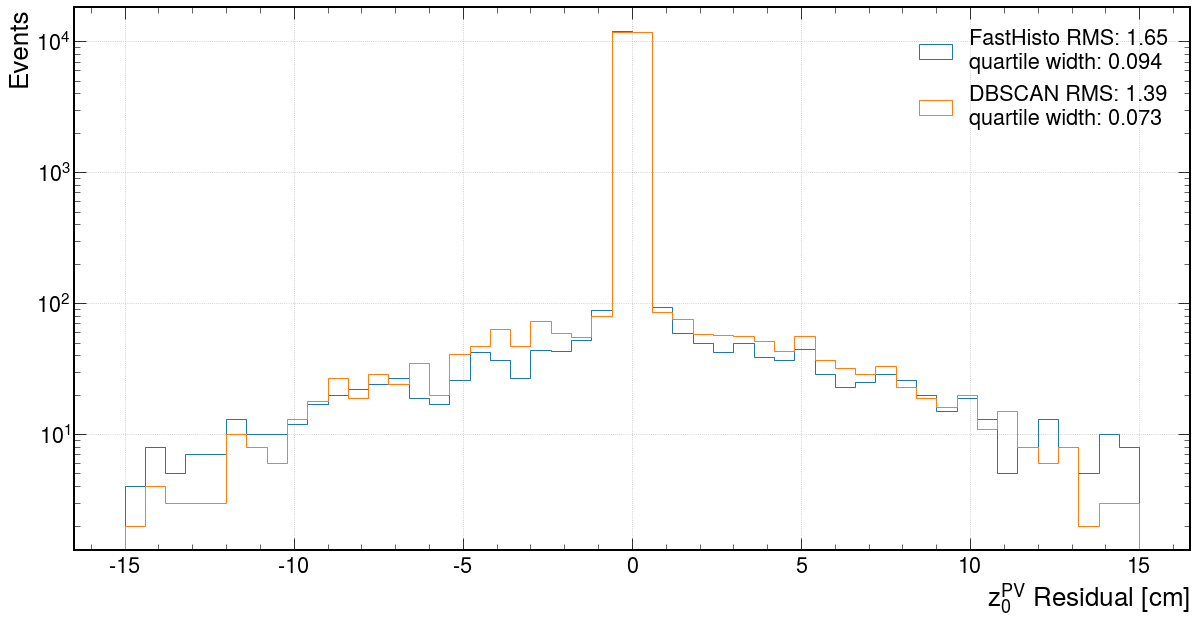

In [324]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

RMS_fh = np.sqrt(np.mean((z0_mc-fh_z0['trk_z0'])**2))
RMS_db = np.sqrt(np.mean((z0_mc-db_z0['trk_z0'])**2))


quartile_fh = round(q_fh[2] - q_fh[0],3)
quartile_db = round(q_db[2] - q_db[0],3)

RMS_fh = round(RMS_fh,2)
RMS_db = round(RMS_db,2)
label_fh = "RMS: " + str(RMS_fh)
label_db = "RMS: " + str(RMS_db)

ax.hist(
    z0_mc - fh_z0["trk_z0"],
    bins=50,
    range=(-15, 15),
    histtype="step",
    label='FastHisto ' + label_fh + '\nquartile width: ' + str(quartile_fh)
)


ax.hist(
    z0_mc - db_z0["trk_z0"],
    bins=50,
    range=(-15, 15),
    histtype="step",
    label='DBSCAN ' + label_db + '\nquartile width: ' + str(quartile_db)
)


ax.legend()

ax.grid(True)
ax.grid(True)
ax.set_yscale('log')


ax.set_xlabel('$z^{PV}_0$ Residual [cm]',ha="right",x=1)
ax.set_ylabel('Events',ha="right",y=1)









Text(0, 1, 'Events')

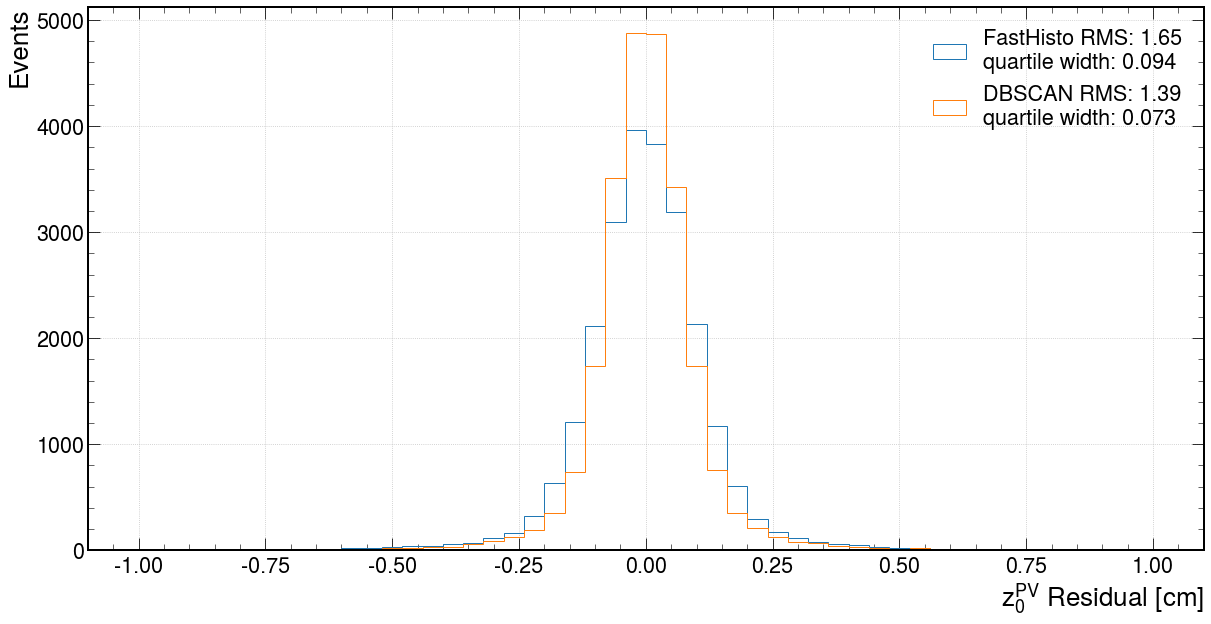

In [326]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

RMS_fh = np.sqrt(np.mean((z0_mc-fh_z0['trk_z0'])**2))
RMS_db = np.sqrt(np.mean((z0_mc-db_z0['trk_z0'])**2))


quartile_fh = round(q_fh[2] - q_fh[0],3)
quartile_db = round(q_db[2] - q_db[0],3)

RMS_fh = round(RMS_fh,2)
RMS_db = round(RMS_db,2)
label_fh = "RMS: " + str(RMS_fh)
label_db = "RMS: " + str(RMS_db)

ax.hist(
    z0_mc - fh_z0["trk_z0"],
    bins=50,
    range=(-1, 1),
    histtype="step",
    label='FastHisto ' + label_fh + '\nquartile width: ' + str(quartile_fh)
)


ax.hist(
    z0_mc - db_z0["trk_z0"],
    bins=50,
    range=(-1, 1),
    histtype="step",
    label='DBSCAN ' + label_db + '\nquartile width: ' + str(quartile_db)
)


ax.legend()

ax.grid(True)


ax.set_xlabel('$z^{PV}_0$ Residual [cm]',ha="right",x=1)
ax.set_ylabel('Events',ha="right",y=1)










Text(0, 1, 'Events')

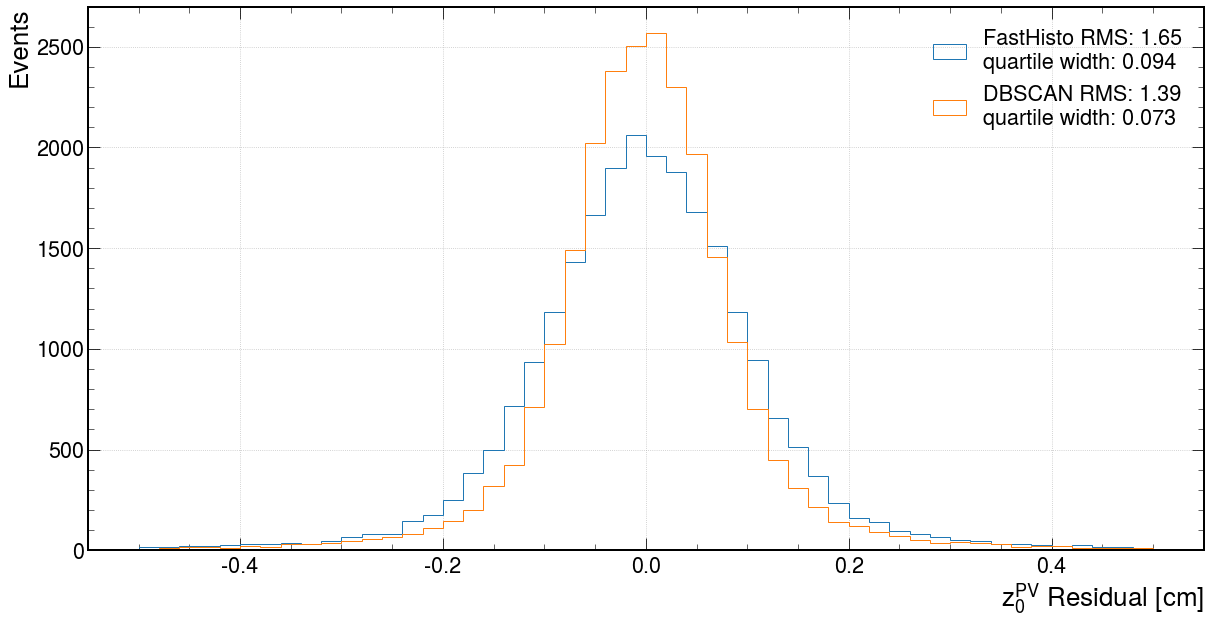

In [327]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

RMS_fh = np.sqrt(np.mean((z0_mc-fh_z0['trk_z0'])**2))
RMS_db = np.sqrt(np.mean((z0_mc-db_z0['trk_z0'])**2))


quartile_fh = round(q_fh[2] - q_fh[0],3)
quartile_db = round(q_db[2] - q_db[0],3)

RMS_fh = round(RMS_fh,2)
RMS_db = round(RMS_db,2)
label_fh = "RMS: " + str(RMS_fh)
label_db = "RMS: " + str(RMS_db)

ax.hist(
    z0_mc - fh_z0["trk_z0"],
    bins=50,
    range=(-0.5, 0.5),
    histtype="step",
    label='FastHisto ' + label_fh + '\nquartile width: ' + str(quartile_fh)
)


ax.hist(
    z0_mc - db_z0["trk_z0"],
    bins=50,
    range=(-0.5, 0.5),
    histtype="step",
    label='DBSCAN ' + label_db + '\nquartile width: ' + str(quartile_db)
)


ax.legend()

ax.grid(True)


ax.set_xlabel('$z^{PV}_0$ Residual [cm]',ha="right",x=1)
ax.set_ylabel('Events',ha="right",y=1)











In [284]:
fh_z0

,entry,trk_z0
0,0,4.980469
1,1,-3.515625
2,2,-0.205078
3,3,2.783203
4,4,-1.347656
...,...,...
24995,24995,-0.117188
24996,24996,-1.933594
24997,24997,8.027344
24998,24998,-4.980469


# 

In [99]:
trk

trk_pt   trk_eta   trk_phi  trk_d0    trk_z0  db_label  \
entry subentry                                                             
0     0         2.623967  1.301414 -0.289234   999.0 -0.878906         0   
      1         3.435026  0.566814 -0.159267   999.0  3.339844         0   
      2         3.774908  1.815973 -0.240375   999.0  4.921875         1   
      3         2.641448 -1.435747 -0.128747   999.0 -0.468750         0   
      4         2.320653  1.837421  0.032604   999.0  4.980469         1   
...                  ...       ...       ...     ...       ...       ...   
24999 194       2.807081 -2.373757 -0.638281   999.0 -0.058594         0   
      195       2.472056 -2.244333 -0.792948   999.0  6.328125         0   
      196       2.391643 -2.093290 -0.658689   999.0 -0.410156         0   
      197       6.140490  2.403961 -0.539389   999.0 -7.441406         0   
      198       5.962409 -2.311289 -0.428627   999.0  1.640625         0   

                trk_fake fh_label  
entry subentry                     
0     0                2        0  
      1                2        0  
      2                1        1  
      3                2        0  
      4                1        1  
...                  ...      ...  
24999 194              2        0  
      195              2        0  
      196              2        0  
      197              2        0  
      198              2        0  

[4562541 rows x 8 columns]

In [46]:
trk.groupby(['entry','db_label'])['trk_z0'].mean().reset_index()

,entry,db_label,trk_z0
0,0,0,-0.670527
1,0,1,4.970129
2,1,0,-0.401582
3,1,1,-3.596191
4,2,0,2.257422
...,...,...,...
49995,24997,1,8.104581
49996,24998,0,0.402878
49997,24998,1,-4.828933
49998,24999,0,1.871745


In [32]:
help(plot_pv_resolution_z0)

Help on function plot_pv_resolution_z0 in module pv_utils:

plot_pv_resolution_z0(z0_gen: <built-in function array>, z0_reco: <built-in function array>, bins: <built-in function array>, ylim: list = [0.0, 0.1], delta: float = 0.1, label: str = 'None') -> dict



In [21]:
help(primary_vertex_efficiency)

Help on function primary_vertex_efficiency in module pv_utils:

primary_vertex_efficiency(z0_gen: <built-in function array>, z0_reco: <built-in function array>, delta: float = 0.1, include_errors: bool = True) -> float
    Returns the primary vertex reconstruction efficiency, which is dependent on the resolution (delta)



# Tqdm test6


In [73]:
from tqdm import tqdm

In [72]:
tqdm.__version__

'4.62.3'

In [74]:
tqdm.pandas()

df = pd.DataFrame(np.random.randint(0, int(1e8), (10000, 1000)))
# Now you can use `progress_apply` instead of `apply`
df.groupby(0).progress_apply(lambda x: x**2)

100%|██████████████████████████████████████████████████████████| 9999/9999 [00:02<00:00, 4422.29it/s]


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,6957838507768281,222091642756,104384514331876,4820095693294281,5454152319086289,1204912460998801,6312581213676516,8660837739758884,1168315877364496,5649398249425441,...,1652730641364100,56923282741504,3024440785847056,9511793097810084,1092028532681025,81641977004025,7344941645943225,8691119891582976,1946086816296676,471903240075556
1,9184264807084900,2256890915508516,9182067451841025,9942559722388225,9753247050243841,1684259192234529,3920234744321284,894196645540641,7700680272390400,2735376609485584,...,2241896077282225,2167319887397289,4779107466325921,724788538078609,9072749571964324,3222565291775449,58738321512649,2954127946572100,1228898622249,610553756496996
2,3996843252830464,273876649509961,166364517708169,702300350902500,3033990149662224,5260564054824516,4929462214196641,5700357361505521,832578707713600,2955869420296464,...,2313301785465616,6251246710410276,458245991435761,3354490669741225,65591662881424,870741244305625,2996732000032225,6323647491463225,322456398899041,640835352455076
3,8095822558750521,410311207699600,485166966568036,97025967230976,740180419950049,359895995355625,814426062498801,2613886894906596,3690017228142144,644514239671225,...,375297243308100,4427314892401041,9798442798823056,7607073545294521,71511952512676,8166385725955249,1964643747787204,3847908729132196,5568376172131809,81113277576681
4,203353902968841,86790408602769,157361243785641,16116796372329,3565076909310225,639965884217209,6076085263765504,3768959983124736,2538516419550864,5079835539891225,...,2654769256949209,756736718287104,7256153199865249,6048589598837041,5225580967712400,2108621603272900,9111132793680516,7978970631607056,148823237671969,4862669811259716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7538604905104,7045360877475904,1106311882445289,1373465094884100,2164269594367521,4648068831502009,1594338696747241,234231913701769,1570971451456,119521349186724,...,6683507717914729,6575149086067849,1200161560649104,2933937464583889,2589999226441225,969115314800689,3195719024937481,9108509381897121,2929060884398401,1455507194232100
9996,5789718992581209,339609796535025,3545481028899364,85202997919209,4650149545920025,993699465954001,1299916730792164,7193599830968464,8980766472812836,765579980221456,...,183213414853225,2134528427715849,7757455760016400,1900040674375936,7051201560073489,9880223027274721,12293277155329,7992012058986916,5588407206922500,1227304012344201
9997,7668100682206864,1945942035285889,1614188918380900,1811990353550400,8622131066195761,840282519091129,236634135428889,7078226740311204,7849483870819969,4672931279580964,...,9828197509954756,1208434604402116,892157041524004,882890953137361,9942031054350756,434220868693089,1838375472390961,1100806691057649,679478792110596,3042792185480100
9998,1437664384737025,4256582240430144,3384578920453956,4478861528944209,841486284274689,6822188419971600,3647354670848889,564640723108900,3816867619324809,5206273024722064,...,9738661132469025,1355707466124489,2202091334190916,18911626562500,6281222194322244,2181095391435601,685174861464025,1838067462090721,749644303214689,8318966393223424


In [75]:
def run_new_dbscan_prog(
    df: pd.DataFrame,
    z0_column: str = "trk_z0",
    pt_column: str = "trk_pt",
    eps: float = 0.08,
    minPts: int = 2,
) -> pd.DataFrame:

    pv_dbscan = df.groupby(level=0).progress_apply(
        lambda x: pv_dbscan_event(x[z0_column], x[pt_column], eps, minPts)
    )
    
    return pv_dbscan.values 



In [76]:
run_new_dbscan_prog(trk)

100%|█████████████████████████████████████████████████████████| 25000/25000 [01:47<00:00, 232.05it/s]


array([0, 0, 1, ..., 0, 0, 0])

In [77]:
from pv_utils import run_pv_dbscan

In [78]:
run_pv_dbscan(trk) 

 70%|████████████████████████████████████████                 | 17558/25000 [01:08<00:29, 255.94it/s]


KeyboardInterrupt: 

# DEBUG FastHisto

In [122]:
trk['trk_z0'].isna().value_counts()

False    4562541
Name: trk_z0, dtype: int64

In [123]:
trk['fh_label'].isna().value_counts()

False    4562541
Name: fh_label, dtype: int64

In [125]:
trk.groupby(level=0)['trk_z0'].first().shape

(25000,)

In [126]:
trk.loc[trk['fh_label']==1].groupby(level=0)['trk_z0'].first().shape

(24997,)

In [136]:
test = trk.groupby(['entry','fh_label'])['trk_z0'].median()

In [174]:
test_array = np.array([0, 1, 0, 1,1,1,1,1])

In [175]:
test_array.sum()

6

In [180]:
np.array([0,0,0,0]).sum()

0

In [181]:
def my_value_counts(x):
    
    total = x.shape[0]

    count_one=x.sum()
    
    count_zero = total - count_one

    return count_zero, count_one
    

In [166]:
test2 = trk.groupby(level=0)['fh_label'].value_counts()

In [182]:
test3 =trk.groupby(level=0)['fh_label'].apply(lambda x: my_value_counts(x))

In [152]:
test2= pd.DataFrame(test2)

In [155]:
test2.columns = ['fh_count']

In [160]:
test2.query('(fh_label==0)& (fh_label!=1)')

,,fh_count
entry,fh_label,
0,0,143
1,0,131
2,0,159
3,0,121
4,0,203
...,...,...
24995,0,171
24996,0,193
24997,0,162


In [135]:
test

0       -1.113281
1        4.980469
2       -1.054688
3       -3.515625
4        1.230469
           ...   
49992    8.027344
49993   -0.175781
49994   -4.980469
49995    1.347656
49996    2.314453
Name: trk_z0, Length: 49997, dtype: float32

In [127]:
trk['fh_label'].value_counts()

0    4130148
1     432393
Name: fh_label, dtype: int64

In [186]:
lmao  = test3.reset_index().explode('fh_label')

In [188]:
lmao[lmao['fh_label']==0]

,entry,fh_label
11055,11055,0
21068,21068,0
22490,22490,0


In [190]:
event11055 = trk.query('entry ==11055')

Text(1, 0, '$z_0$ [cm]')

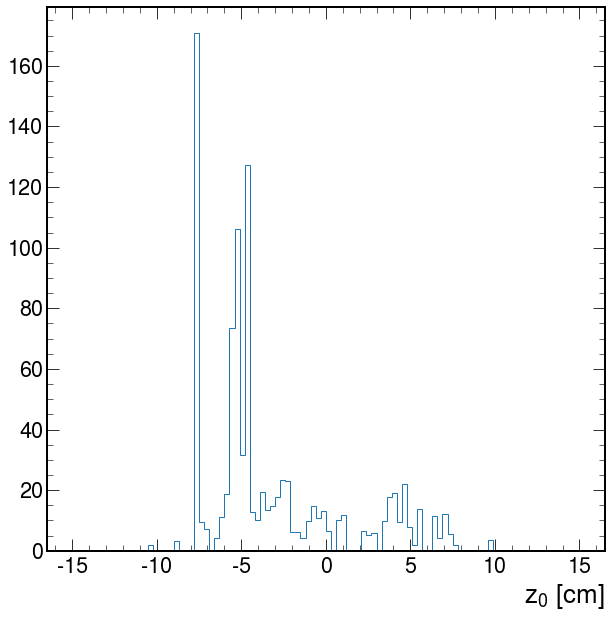

In [191]:
h, be, _ = plt.hist(
    event11055["trk_z0"].values, bins=be_fh, histtype="step", weights=event11055["trk_pt"]
)
plt.xlabel(r"$z_0$ [cm]")

In [198]:
histo = np.histogram(event11055.trk_z0.values, bins=be_fh, weights=event11055.trk_pt.values)[0]

In [201]:
labels = np.zeros(len(event11055.trk_z0.values), dtype=int)

In [203]:
max_idx = np.argmax(histo)

In [204]:
max_idx

24

In [209]:
lower_bin_bound = be_fh[max_idx]
upper_bin_bound = be_fh[max_idx + 1]

In [211]:
lower_bin_bound

-7.799999999999983

In [238]:
in_max_bin_mask =(event11055.trk_z0.values > lower_bin_bound) & (event11055.trk_z0.values <= upper_bin_bound)

In [239]:
in_max_bin_mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [221]:
labels[in_max_bin_mask] = 1

In [222]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

(-7.799999999999983, -7.499999999999982)

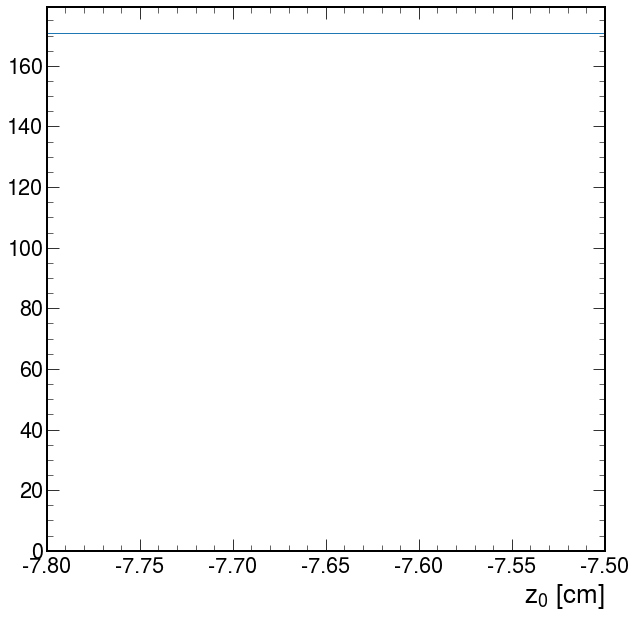

In [223]:
h, be, _ = plt.hist(
    event11055["trk_z0"].values, bins=be_fh, histtype="step", weights=event11055["trk_pt"]
)
plt.xlabel(r"$z_0$ [cm]")
plt.xlim(lower_bin_bound, upper_bin_bound)

In [192]:
event21068 = trk.query('entry ==21068')

In [248]:
event21068.trk_pt

entry  subentry
21068  0            1.973339
       1            2.546916
       2           23.722233
       3            2.723082
       4            3.334937
                     ...    
       162          3.785204
       163          2.736506
       164          2.013787
       165          2.277802
       166          3.495594
Name: trk_pt, Length: 167, dtype: float32

In [196]:
event22490 = trk.query('entry ==22490')
event22490

trk_pt   trk_eta   trk_phi  trk_d0    trk_z0  db_label  \
entry subentry                                                             
22490 0         1.973690 -0.816397 -0.379882   999.0  0.878906         0   
      1         3.441415 -1.090775 -0.193600   999.0  1.289062         0   
      2         2.734484 -1.016723 -0.268425   999.0  5.742188         0   
      3         3.095067 -0.461914 -0.111828   999.0  8.554688         0   
      4         2.986015 -1.260110 -0.178101   999.0  3.164062         0   
...                  ...       ...       ...     ...       ...       ...   
      162       2.294751  0.985103 -0.304124   999.0  5.390625         0   
      163       2.469857  0.042956 -0.927577   999.0  4.570312         0   
      164       4.503856 -1.993254 -1.077890   999.0  1.113281         0   
      165       2.399396  2.343373 -0.606635   999.0 -1.347656         0   
      166       2.040810 -2.173125 -0.539606   999.0 -0.468750         0   

                trk_fake  fh_label  is_pv  
entry subentry                             
22490 0                2         0      0  
      1                2         0      0  
      2                2         0      0  
      3                2         0      0  
      4                2         0      0  
...                  ...       ...    ...  
      162              2         0      0  
      163              2         0      0  
      164              2         0      0  
      165              2         0      0  
      166              2         0      0  

[167 rows x 9 columns]

<AxesSubplot:>

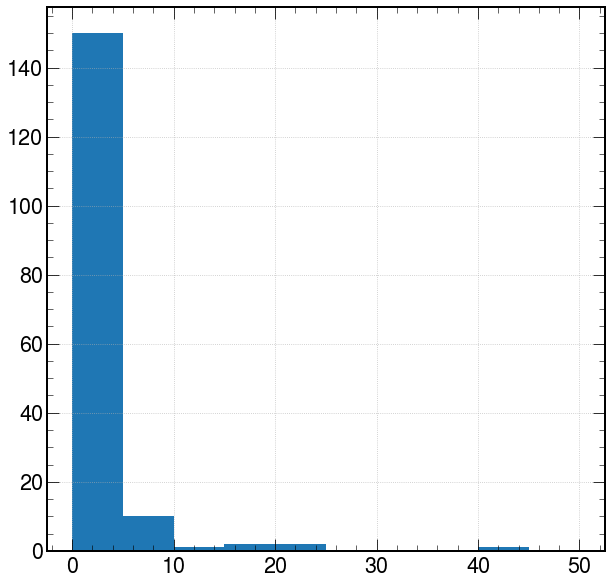

In [231]:
event21068['trk_pt'].hist(range = (0, 50))

In [232]:
from pv_utils import fast_histo_event

In [233]:
fast_histo_event(event21068.trk_z0.values, event21068.trk_z0.values, bin_edges=be_fh)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [262]:
trk[trk['trk_pt']==np.inf]

,,trk_pt,trk_eta,trk_phi,trk_d0,trk_z0,db_label,trk_fake,fh_label,is_pv
entry,subentry,,,,,,,,,
9773,67,inf,NaN,0.785398,999.0,8.203125,0,0,0,0
10450,29,inf,NaN,-0.785398,999.0,4.511719,0,0,0,0
21068,84,inf,NaN,2.356194,999.0,-13.535156,0,0,0,0
21270,77,inf,NaN,0.785398,999.0,-11.777344,0,0,0,0
22776,133,inf,NaN,-2.356194,999.0,-0.937500,0,0,0,0


In [265]:
mc.query('(entry==9773) | (entry==10450) | (entry==21068) | (entry==21270) | (entry==22776)')

,,pv_L1reco_z0,pv_L1reco_sum,pv_MC
entry,subentry,,,
9773,0,-6.331171,257.690857,-6.231975
10450,0,1.498646,227.127701,1.521915
21068,0,-5.236532,144.172363,-5.383003
21270,0,-11.897167,363.781281,-11.918439
22776,0,-0.460405,169.392410,-0.594745


/mnt/storage/lborgna/condaenv/db-clustering/lib/python3.8/site-packages/numpy/lib/function_base.py:1292: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


Text(1, 0, '$z_0$ [cm]')

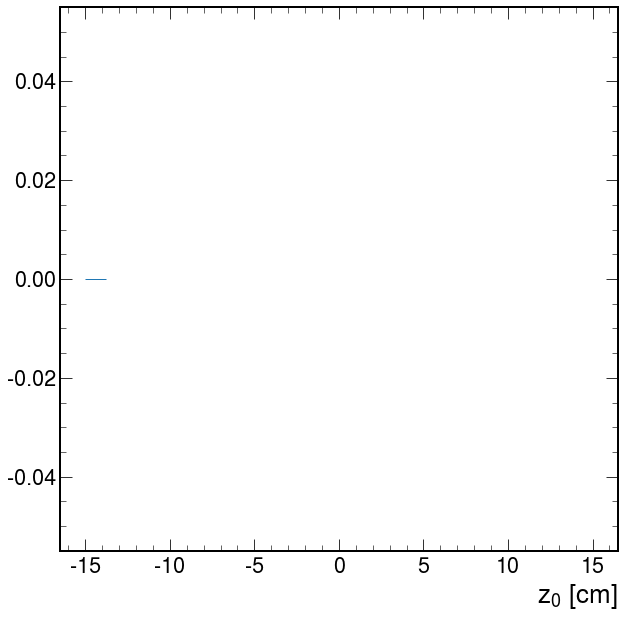

In [250]:
h, be, _ = plt.hist(
    event21068["trk_z0"].values, bins=be_fh, histtype="step", weights=event21068["trk_pt"].values
)
plt.xlabel(r"$z_0$ [cm]")

Text(1, 0, '$z_0$ [cm]')

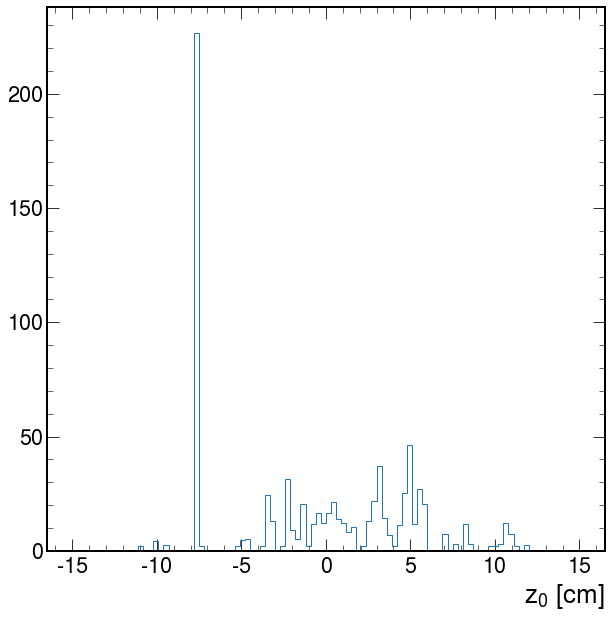

In [197]:
h, be, _ = plt.hist(
    event22490["trk_z0"].values, bins=be_fh, histtype="step", weights=event22490["trk_pt"]
)
plt.xlabel(r"$z_0$ [cm]")

In [241]:
fast_histo_event(event22490.trk_z0.values, event22490.trk_z0.values, bin_edges=be_fh)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])